# Libraries

In [1]:
import time
start_time = time.time()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Thesis/CNN.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Thesis/Bongard Testing.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
from os import path
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Input
from sklearn.metrics import accuracy_score
import time
import natsort
from PIL import Image

# Functions:

#### 1) Function to plot bongard images

In [6]:
def load_and_resize_images(folder_path, target_size):
    image_paths = glob.glob(os.path.join(folder_path, '*.png'))
    image_paths = natsort.natsorted(image_paths)
    images = []
    for img_path in image_paths:
        with Image.open(img_path) as img:
            img = img.resize(target_size)
            if img.mode == 'RGBA':
                img = img.convert('L')
            img_arr = np.array(img)
            if len(img_arr.shape) == 2:
                img_arr = img_arr[..., np.newaxis]
            images.append(img_arr)
    return np.array(images)

def plot_image_from_array(images_array, image_index, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(images_array[image_index, :, :, 0], cmap='gray', aspect='auto')
    plt.title(f"Image {image_index + 1}")
    plt.axis('off')
    plt.show()

folder_B_path = '/content/Bongard Testing/BP'
target_size = (330, 516)
images_array = load_and_resize_images(folder_B_path, target_size)

#### 2) Function to preprocess images

In [7]:
# Preprocessing:
def load_imgs(list_of_img_paths):
    alpaca_lst = []
    for imgs in list_of_img_paths:
        img=tf.keras.utils.load_img(
                            imgs,
                            color_mode = "grayscale",
                            target_size=None,
                            interpolation="nearest",
                            keep_aspect_ratio=False)

        input_arr = tf.keras.utils.img_to_array(img)

        inpt_img_arr = input_arr / 255.0
        alpaca_lst.append(inpt_img_arr)
    imgs_arr =np.array(alpaca_lst)
    return imgs_arr

#### 3) Function to plot any image with their labels

In [8]:
import matplotlib.pyplot as plt

def plot_images_with_labels(images, labels):
    plt.figure(figsize=(12, 8))

    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns for a 2x5 grid of subplots
        plt.imshow(images[i], cmap='gray')  # Display the image
        plt.title(f'Label: {labels[i]}')    # Set the title with the corresponding label
        plt.axis('off')                     # Turn off axis labels and ticks

    plt.tight_layout()
    plt.show()

#### 4) functions to create masked labels

In [9]:
# Generate masked labels for heads except selected head
def create_masked_labels(selected_head_name, excluded_head_names, labels):
    masked_labels = {}
    masked_labels[selected_head_name] = labels
    for head_name in excluded_head_names:
        masked_labels[head_name] = np.full_like(labels, -1)
    return masked_labels
def masked_label(selected_head_name,Ci_y_train):
    # Define the list of output head layer names
    output_names = ['center_vs_notincenter','circle_vs_notcircle','Closed_vs_Open_figure',
                'Colinear_vs_Noncolinear','Concave_vs_Convex','Four_vs_notfour_side','Triangle_vs_notTriangle',
                'Clockwise_vs_Anticlock_wise','Left_vs_Right','Parallel_vs_perpendicular','Filled_vs_Unfilled',
                'Complete_vs_Incomplete','Intersect_vs_NonIntersect','M_cluster_vs_N_clusters','Above_vs_Below',
                'Same_vs_Not_Same','Size_big_vs_Small','Symmetery_vs_Non_symmetery','Horizontal_vs_Vertical',
                'Empty_vs_Non_Empty']

    # Exclude the selected head from generating masked labels
    excluded_head_names = [name for name in output_names if name != selected_head_name]

    # Generate masked labels for all excluded heads
    Ci_masked_labels = create_masked_labels(selected_head_name, excluded_head_names, Ci_y_train)
    return Ci_masked_labels

#### 5) Function to preprocess and split the data into training and testing

In [10]:
def data_load_split(Classifier_path,folder_A,folder_B):
    os.getcwd()
    dataset_path = os.getcwd()
    a = os.path.join('/content/CNN',Classifier_path)
    A = os.path.join(dataset_path, a)
    A_A = os.path.join(A, folder_A)
    A_B = os.path.join(A, folder_B)
    A_A = glob.glob(A_A +"/*.png")
    A_B = glob.glob(A_B +"/*.png")
    A_A_arr =load_imgs(A_A)
    A_B_arr =load_imgs(A_B)


    # Generate labels corresponding to above concept classes.
    A_A_labels =  np.zeros([len(A_A_arr), 1], dtype = int)  #labeled as 0
    A_B_labels =  np.ones([len(A_B_arr), 1], dtype = int) #labeled as 1

    Ci_X = np.concatenate((A_A_arr, A_B_arr), axis=0)
    Ci_y = np.concatenate((A_A_labels , A_B_labels), axis=0)

    # Split the data into training and testing sets
    Ci_X_train, Ci_X_test, Ci_y_train, Ci_y_test = train_test_split(Ci_X, Ci_y,
                                                                    test_size=0.2, random_state=42, shuffle=True)

    return Ci_X_train,Ci_X_test,Ci_y_train,Ci_y_test

#### Automate the code to load every classifier images and split.

In [11]:
# Path to the main folder
main_folder_path = "/content/CNN"

# Get the names of first-level subfolders in "A"
subfolder_names = [name for name in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, name))]
subfolder_names = sorted(subfolder_names)
start_time = time.time()
# Iterate through the first-level subfolders and call data_load_split
for i, subfolder_name in enumerate(subfolder_names):
    subfolder_path = os.path.join(main_folder_path, subfolder_name)
    subsubfolder_names = [name for name in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, name))]

    if len(subsubfolder_names) == 2:
        print(f'classifier C{i}:', subfolder_name)
#         print(subsubfolder_names[0],subsubfolder_names[1])
        exec(f'C{i}_X_train, C{i}_X_test, C{i}_y_train, C{i}_y_test = data_load_split(subfolder_name,subsubfolder_names[0],subsubfolder_names[1])')
        print("Shape:")

        print(locals()[f'C{i}_X_train'].shape, locals()[f'C{i}_y_train'].shape,locals()[f'C{i}_X_test'].shape,
        locals()[f'C{i}_y_test'].shape)
        print('\n')
end_time = time.time()
Preprocess_Time = end_time - start_time
print("Time taken for Preprocess data:", Preprocess_Time, "seconds")

classifier C0: B) center  vs not incenter
Shape:
(3680, 100, 100, 1) (3680, 1) (920, 100, 100, 1) (920, 1)


classifier C1: C) Circle vs not circle
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C2: D) Closed figure vs Open figure
Shape:
(1232, 100, 100, 1) (1232, 1) (308, 100, 100, 1) (308, 1)


classifier C3: E) Co-linear vs Non-colinear
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C4: F) Concave vs Convex
Shape:
(1600, 100, 100, 1) (1600, 1) (400, 100, 100, 1) (400, 1)


classifier C5: G) Four sides vs not four side
Shape:
(5600, 100, 100, 1) (5600, 1) (1400, 100, 100, 1) (1400, 1)


classifier C6: H) Triangle vs not Triangle
Shape:
(5584, 100, 100, 1) (5584, 1) (1396, 100, 100, 1) (1396, 1)


classifier C7: I) Clockwise vs Anticlock wise
Shape:
(2400, 100, 100, 1) (2400, 1) (600, 100, 100, 1) (600, 1)


classifier C8: J) Left vs Right
Shape:
(2000, 100, 100, 1) (2000, 1) (500, 100, 100, 1) (500, 1)


classifier C9: K) 

# Multi-Head CNN

In [12]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model


def Multi_head_CNN():

  # Input Shape
  input_shape = (100, 100, 1)
  input_layer = Input(shape=input_shape)

  # CNN common model:
  CNN_L1 = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(input_layer)
  CNN_L2 = BatchNormalization()(CNN_L1)
  CNN_L3 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L2)

  CNN_L4 = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L3)
  CNN_L5 = BatchNormalization()(CNN_L4)
  CNN_L6 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L5)

  CNN_L7 = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L6)
  CNN_L8 = BatchNormalization()(CNN_L7)
  CNN_L9 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L8)

  CNN_L10 = Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu')(CNN_L9)
  CNN_L11 = BatchNormalization()(CNN_L10)
  CNN_L12 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(CNN_L11)

  CNN_L13 = Flatten()(CNN_L12)

  # Add more layers
  Common_Layer = Dense(128, activation='relu')(CNN_L13)
  Common_Layer = Dense(10, activation='relu')(Common_Layer)

  # Individual Head: Center vs not incenter
  center_vs_notincenter = Dense(1, activation='sigmoid', name='center_vs_notincenter')(Common_Layer)

  # Individual Head: Circle vs not circle
  circle_vs_notcircle = Dense(1, activation='sigmoid', name='circle_vs_notcircle')(Common_Layer)

  # Individual Head: Closed_vs_Open_figure
  Closed_vs_Open_figure = Dense(1, activation='sigmoid', name='Closed_vs_Open_figure')(Common_Layer)

  # Individual Head: Co-linear_vs_Non-colinear
  Colinear_vs_Noncolinear = Dense(1, activation='sigmoid', name='Colinear_vs_Noncolinear')(Common_Layer)

  # Individual Head: Concave_vs_Convex
  Concave_vs_Convex = Dense(1, activation='sigmoid', name='Concave_vs_Convex')(Common_Layer)


  Four_vs_notfour_side =Dense(1, activation='sigmoid', name='Four_vs_notfour_side')(Common_Layer)


  Triangle_vs_notTriangle =Dense(1, activation='sigmoid', name='Triangle_vs_notTriangle')(Common_Layer)


  Clockwise_vs_Anticlock_wise =  Dense(1, activation='sigmoid', name='Clockwise_vs_Anticlock_wise')(Common_Layer)


  Left_vs_Right =  Dense(1, activation='sigmoid', name='Left_vs_Right')(Common_Layer)


  Parallel_vs_perpendicular =  Dense(1, activation='sigmoid', name='Parallel_vs_perpendicular')(Common_Layer)


  Filled_vs_Unfilled =  Dense(1, activation='sigmoid', name='Filled_vs_Unfilled')(Common_Layer)


  Complete_vs_Incomplete =  Dense(1, activation='sigmoid', name='Complete_vs_Incomplete')(Common_Layer)


  Intersect_vs_NonIntersect =  Dense(1, activation='sigmoid', name='Intersect_vs_NonIntersect')(Common_Layer)


  M_cluster_vs_N_clusters =  Dense(1, activation='sigmoid', name='M_cluster_vs_N_clusters')(Common_Layer)


  Above_vs_Below =  Dense(1, activation='sigmoid', name='Above_vs_Below')(Common_Layer)


  Same_vs_Not_Same =  Dense(1, activation='sigmoid', name='Same_vs_Not_Same')(Common_Layer)

  Size_big_vs_Small =  Dense(1, activation='sigmoid', name='Size_big_vs_Small')(Common_Layer)

  Symmetery_vs_Non_symmetery = Dense(1, activation='sigmoid', name='Symmetery_vs_Non_symmetery')(Common_Layer)

  Horizontal_vs_Vertical = Dense(1, activation='sigmoid', name='Horizontal_vs_Vertical')(Common_Layer)

  Empty_vs_Non_Empty = Dense(1, activation='sigmoid', name='Empty_vs_Non_Empty')(Common_Layer)


  # Create the model
  model = Model(inputs=input_layer, outputs=[
                                            center_vs_notincenter,
                                            circle_vs_notcircle,
                                            Closed_vs_Open_figure,
                                            Colinear_vs_Noncolinear,
                                            Concave_vs_Convex,
                                            Four_vs_notfour_side,
                                            Triangle_vs_notTriangle,
                                            Clockwise_vs_Anticlock_wise,
                                            Left_vs_Right,
                                            Parallel_vs_perpendicular,
                                            Filled_vs_Unfilled,
                                            Complete_vs_Incomplete,
                                            Intersect_vs_NonIntersect,
                                            M_cluster_vs_N_clusters,
                                            Above_vs_Below,
                                            Same_vs_Not_Same,
                                            Size_big_vs_Small,
                                            Symmetery_vs_Non_symmetery,
                                            Horizontal_vs_Vertical,
                                            Empty_vs_Non_Empty
                                            ])

  # Compile the model with appropriate loss functions for each head
  model.compile(optimizer='adam',


                loss={
                'center_vs_notincenter': 'binary_crossentropy',
                'circle_vs_notcircle': 'binary_crossentropy',
                'Closed_vs_Open_figure': 'binary_crossentropy',
                'Colinear_vs_Noncolinear': 'binary_crossentropy',
                'Concave_vs_Convex': 'binary_crossentropy',
                'Four_vs_notfour_side': 'binary_crossentropy',
                'Triangle_vs_notTriangle': 'binary_crossentropy',
                'Clockwise_vs_Anticlock_wise': 'binary_crossentropy',
                'Left_vs_Right': 'binary_crossentropy',
                'Parallel_vs_perpendicular': 'binary_crossentropy',
                'Filled_vs_Unfilled': 'binary_crossentropy',
                'Complete_vs_Incomplete': 'binary_crossentropy',
                'Intersect_vs_NonIntersect': 'binary_crossentropy',
                'M_cluster_vs_N_clusters': 'binary_crossentropy',
                'Above_vs_Below': 'binary_crossentropy',
                'Same_vs_Not_Same': 'binary_crossentropy',
                'Size_big_vs_Small':'binary_crossentropy',
                'Symmetery_vs_Non_symmetery':'binary_crossentropy',
                'Horizontal_vs_Vertical':'binary_crossentropy',
                'Empty_vs_Non_Empty':'binary_crossentropy',
                })
  return model

### Training Models

In [13]:
# Creating new model for cold start.
model = Multi_head_CNN()

In [14]:
Final_test_accuracies = []

#### Define traning and label data

In [15]:
X = [C0_X_train, C1_X_train,C2_X_train,C3_X_train, C4_X_train,C5_X_train,C6_X_train, C7_X_train,C8_X_train,C9_X_train,
     C10_X_train,C11_X_train,C12_X_train, C13_X_train,C14_X_train,C15_X_train,C16_X_train,C17_X_train,C18_X_train,
     C19_X_train]

Y=  [C0_y_train,C1_y_train,C2_y_train,C3_y_train,C4_y_train,C5_y_train,C6_y_train,C7_y_train,C8_y_train,C9_y_train,
C10_y_train,C11_y_train,C12_y_train,C13_y_train,C14_y_train,C15_y_train,C16_y_train,C17_y_train,C18_y_train,C19_y_train]

output_names = ['center_vs_notincenter','circle_vs_notcircle','Closed_vs_Open_figure',
                'Colinear_vs_Noncolinear','Concave_vs_Convex','Four_vs_notfour_side','Triangle_vs_notTriangle',
                'Clockwise_vs_Anticlock_wise','Left_vs_Right','Parallel_vs_perpendicular','Filled_vs_Unfilled',
                'Complete_vs_Incomplete','Intersect_vs_NonIntersect','M_cluster_vs_N_clusters','Above_vs_Below',
                'Same_vs_Not_Same','Size_big_vs_Small','Symmetery_vs_Non_symmetery','Horizontal_vs_Vertical',
                'Empty_vs_Non_Empty']

# Training Model

In [16]:
training_loss_epoch_0=[]
training_loss_epoch_1=[]
training_loss_epoch_2=[]
training_loss_epoch_3=[]
training_loss_epoch_4=[]
training_loss_epoch_5=[]
training_loss_epoch_6=[]
training_loss_epoch_7=[]
training_loss_epoch_8=[]
training_loss_epoch_9=[]

In [17]:
# Define epochs and number of heads to be train
epochs=10
num_heads=20

for epoch in range(epochs):
  for i in range(num_heads):
    print(f'epoch {epoch}',f'Head {i}')

    if i==3 or i==4 or i==7 or i==9 or i==15:

      Model_history=model.fit(X[i], {output_names[i]: Y[i]}, epochs=10)
      # All training loss and accuracy store in variables for all 10 epochs

      training_loss = Model_history.history['loss']
      print("Model history training loss: ",training_loss)
      print()

      # Append all epoch 0 loss to the list and similarly till 10 epochs.
      for Model_epoch in range(10):
        globals()[f'training_loss_epoch_{Model_epoch}'].append(training_loss[Model_epoch])
        print("Append training loss ", training_loss[Model_epoch])

    else:
      Model_history1= model.fit(X[i], {output_names[i]: Y[i]}, epochs=1)
      training_loss = Model_history1.history['loss']
      print("Model history1 training loss: ",training_loss)
      print()
      globals()[f'training_loss_epoch_{epoch}'].append(training_loss[0])
      print("Append training loss2 ", training_loss[0])
    print()

epoch 0 Head 0


115/115 [==============================] - 7s 7ms/step - loss: 0.3521 - center_vs_notincenter_loss: 0.3521 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.35210734605789185]

Append training loss2  0.35210734605789185

epoch 0 Head 1


50/50 [==============================] - 1s 7ms/step - loss: 0.3798 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.3798 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.37980833649635315]

Append training loss2  0.37980833649635315

epoch 0 Head 2


39/39 [==============================] - 2s 11ms/step - loss: 0.4555 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.4555 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.4554961025714874]

Append training loss2  0.4554961025714874

epoch 0 Head 3
Epoch 1/10


50/50 [==============================] - 1s 7ms/step - loss: 0.6834 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.6834 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.4847 - center_vs_notincenter_loss: 0.0000e+00 - circ

50/50 [==============================] - 1s 7ms/step - loss: 1.3988 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 1.3988 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.6935 - center_vs_notincenter_loss: 0.0000e+00 - circ

175/175 [==============================] - 2s 7ms/step - loss: 0.5199 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.5199 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.5199214816093445]

Append training loss2  0.5199214816093445

epoch 0 Head 6


175/175 [==============================] - 2s 7ms/step - loss: 0.5580 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.5580 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.5579713582992554]

Append training loss2  0.5579713582992554

epoch 0 Head 7
Epoch 1/10


75/75 [==============================] - 2s 7ms/step - loss: 0.7074 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.7074 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6928 - center_vs_notincenter_loss: 0.0000e+00 - circ

63/63 [==============================] - 2s 8ms/step - loss: 0.6894 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.6894 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.6893591284751892]

Append training loss2  0.6893591284751892

epoch 0 Head 9
Epoch 1/10


25/25 [==============================] - 1s 7ms/step - loss: 0.6968 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.6968 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - loss: 0.6882 - center_vs_notincenter_loss: 0.0000e+00 - circ

55/55 [==============================] - 1s 7ms/step - loss: 0.7161 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.7161 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.7161148190498352]

Append training loss2  0.7161148190498352

epoch 0 Head 11


100/100 [==============================] - 2s 7ms/step - loss: 0.7381 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.7381 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.7381035089492798]

Append training loss2  0.7381035089492798

epoch 0 Head 12


112/112 [==============================] - 2s 8ms/step - loss: 0.5467 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.5467 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.5466822981834412]

Append training loss2  0.5466822981834412

epoch 0 Head 13


50/50 [==============================] - 2s 15ms/step - loss: 0.6944 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.6944 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.6944023966789246]

Append training loss2  0.6944023966789246

epoch 0 Head 14


60/60 [==============================] - 2s 7ms/step - loss: 0.7095 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.7095 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.7095231413841248]

Append training loss2  0.7095231413841248

epoch 0 Head 15
Epoch 1/10


80/80 [==============================] - 2s 7ms/step - loss: 0.6936 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.6936 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Epoch 2/10
80/80 [==============================] - 1s 7ms/step - loss: 0.6932 - center_vs_notincenter_loss: 0.0000e+00 - circ

50/50 [==============================] - 1s 7ms/step - loss: 0.6357 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.6357 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.6357397437095642]

Append training loss2  0.6357397437095642

epoch 0 Head 17


137/137 [==============================] - 2s 9ms/step - loss: 0.7004 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.7004 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.7003538012504578]

Append training loss2  0.7003538012504578

epoch 0 Head 18


50/50 [==============================] - 1s 7ms/step - loss: 0.4982 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.4982 - Empty_vs_Non_Empty_loss: 0.0000e+00
Model history1 training loss:  [0.4981951117515564]

Append training loss2  0.4981951117515564

epoch 0 Head 19


25/25 [==============================] - 1s 7ms/step - loss: 0.5119 - center_vs_notincenter_loss: 0.0000e+00 - circle_vs_notcircle_loss: 0.0000e+00 - Closed_vs_Open_figure_loss: 0.0000e+00 - Colinear_vs_Noncolinear_loss: 0.0000e+00 - Concave_vs_Convex_loss: 0.0000e+00 - Four_vs_notfour_side_loss: 0.0000e+00 - Triangle_vs_notTriangle_loss: 0.0000e+00 - Clockwise_vs_Anticlock_wise_loss: 0.0000e+00 - Left_vs_Right_loss: 0.0000e+00 - Parallel_vs_perpendicular_loss: 0.0000e+00 - Filled_vs_Unfilled_loss: 0.0000e+00 - Complete_vs_Incomplete_loss: 0.0000e+00 - Intersect_vs_NonIntersect_loss: 0.0000e+00 - M_cluster_vs_N_clusters_loss: 0.0000e+00 - Above_vs_Below_loss: 0.0000e+00 - Same_vs_Not_Same_loss: 0.0000e+00 - Size_big_vs_Small_loss: 0.0000e+00 - Symmetery_vs_Non_symmetery_loss: 0.0000e+00 - Horizontal_vs_Vertical_loss: 0.0000e+00 - Empty_vs_Non_Empty_loss: 0.5119
Model history1 training loss:  [0.5119394063949585]

Append training loss2  0.5119394063949585

epoch 1 Head 0
115/115 [======

In [20]:
training_loss_epoch_0_avg=sum(training_loss_epoch_0)/len(training_loss_epoch_0)
training_loss_epoch_1_avg=sum(training_loss_epoch_1)/len(training_loss_epoch_1)
training_loss_epoch_2_avg=sum(training_loss_epoch_2)/len(training_loss_epoch_2)
training_loss_epoch_3_avg=sum(training_loss_epoch_3)/len(training_loss_epoch_3)
training_loss_epoch_4_avg=sum(training_loss_epoch_4)/len(training_loss_epoch_4)
training_loss_epoch_5_avg=sum(training_loss_epoch_5)/len(training_loss_epoch_5)
training_loss_epoch_6_avg=sum(training_loss_epoch_6)/len(training_loss_epoch_6)
training_loss_epoch_7_avg=sum(training_loss_epoch_7)/len(training_loss_epoch_7)
training_loss_epoch_8_avg=sum(training_loss_epoch_8)/len(training_loss_epoch_8)
training_loss_epoch_9_avg=sum(training_loss_epoch_9)/len(training_loss_epoch_9)

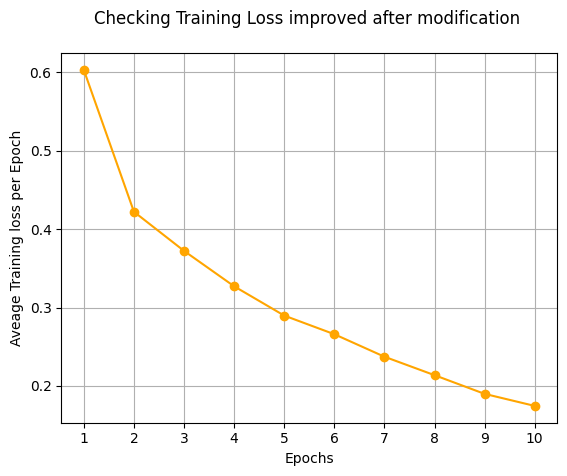

In [31]:
Epochs = range(1,11)

Training_loss=[training_loss_epoch_0_avg,training_loss_epoch_1_avg,training_loss_epoch_2_avg,training_loss_epoch_3_avg,training_loss_epoch_4_avg,training_loss_epoch_5_avg,training_loss_epoch_6_avg,
               training_loss_epoch_7_avg,training_loss_epoch_8_avg,training_loss_epoch_9_avg]

# Create the plot
plt.plot(Epochs, Training_loss, marker='o',color='orange')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Aveage Training loss per Epoch')
plt.title('Checking Training Loss improved after modification \n')

# Display the plot
plt.grid(True)
plt.xticks(Epochs)
plt.show()

In [26]:
def check_accuracy(X_test,Y_test,i):
  predictions = model.predict(X_test)
  predictions_head = predictions[i]
  threshold = 0.5
  binary_predictions_head = (predictions_head > threshold).astype(int)
  print("binary_predictions_head: ",np.unique(binary_predictions_head))
  accuracy_classifier = accuracy_score(Y_test, binary_predictions_head)
  print(f'Accuracy for Classifier C{i}:', accuracy_classifier)
  return accuracy_classifier

for i in range(num_heads):
  X_Test = globals()[f'C{i}_X_test']
  Y_test = globals()[f'C{i}_y_test']

  Temp_var = check_accuracy(X_Test,Y_test,i)
  Rounded_accuracy = round(Temp_var, 2)
  Final_test_accuracies.append(Rounded_accuracy)

29/29 [==============================] - 0s 5ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C0: 0.4934782608695652
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C1: 0.47
10/10 [==============================] - 0s 10ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C2: 0.5227272727272727
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [1]
Accuracy for Classifier C3: 0.5025
13/13 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C4: 0.535
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C5: 0.5357142857142857
44/44 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C6: 0.5802292263610315
19/19 [==============================] - 0s 3ms/step
binary_predictions_head:  [0 1]
Accuracy for Classifier C7: 0.4

In [27]:
Final_test_accuracies

[0.49,
 0.47,
 0.52,
 0.5,
 0.54,
 0.54,
 0.58,
 0.49,
 0.38,
 0.52,
 0.51,
 0.46,
 0.52,
 0.5,
 0.48,
 0.54,
 0.59,
 0.55,
 0.5,
 0.74]

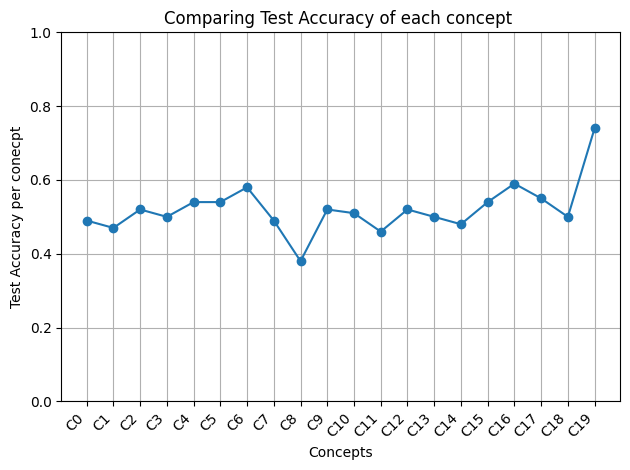

In [28]:
Concepts = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
                      'C15', 'C16', 'C17', 'C18', 'C19']

# Create the plot
plt.plot(Concepts, Final_test_accuracies, marker='o')

# Add labels and title
plt.xlabel('Concepts')
plt.ylabel('Test Accuracy per conecpt')
plt.title('Comparing Test Accuracy of each concept ')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.ylim(0, 1)
# Display the plot
plt.grid(True)
plt.tight_layout()  # To rotate the x-axis labels by 45 degrees.
plt.show()


In [29]:
end_time = time.time()
final_time = end_time - start_time
print()
print("Total Time to be taked for this experiment:", final_time, "seconds")
print()


Total Time to be taked for this experiment: 655.8639445304871 seconds

